# Project: Transfer Learning in PyTorch
## Part 1. Data exploration and visualization


### Dataset: Flower 102

The dataset is the [Oxford 102 collection](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/) of flowers

In [1]:
from torchvision import transforms, models, datasets
import torch, torchvision
from torch.utils.data import DataLoader, sampler
import torch.nn as nn
import numpy as np
import pandas as pd
import os, glob, math, random
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.size'] = 14
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = 'all'


## Data Exploration
 
The standard architecture of the data folders is:

```
/datadir
    /train
            /class_1
            /class_2
            .
            .
    /valid
            /class_1
            /class_2
            .
            .
    /test
            /class_1
            /class_2
            .
            .
```

Below we take a look at the number of images in each category and the size of the images.

In [2]:
datadir = './flower_data/'
traindir = datadir + 'train/'
validdir = datadir + 'valid/'
testdir = datadir + 'valid/'
categories = []
img_categories = []
n_train = []
n_valid = []
n_test = []
hs = []
ws = []

# Iterate through each category
for d in os.listdir(traindir):
    categories.append(d)

    # Number of images in each category
    train_imgs = os.listdir(traindir + d)
    valid_imgs = os.listdir(validdir + d)
    test_imgs = os.listdir(testdir + d)
    n_train.append(len(train_imgs))
    n_valid.append(len(valid_imgs))
    n_test.append(len(test_imgs))

    # Find stats for train images
    for i in train_imgs:
        img_categories.append(d)
        img = Image.open(traindir + d + '/' + i)
        img_array = np.array(img)
        # Shape
        hs.append(img_array.shape[0])
        ws.append(img_array.shape[1])

# Dataframe of categories
cat_df = pd.DataFrame({'category': categories,
                       'n_train': n_train,
                       'n_valid': n_valid, 
                       'n_test': n_test}).sort_values('category')

# Dataframe of training images
image_df = pd.DataFrame({ 'category': img_categories,'height': hs, 'width': ws })

cat_df.sort_values('n_train', ascending = False, inplace = True)
cat_df.head()
cat_df.tail()

,category,n_train,n_valid,n_test
76,7,33,1,1
18,45,33,4,4
77,33,31,7,7
80,34,28,7,7
71,1,27,8,8


#### Distribution of Images

There are between 27 and 206 training images in each category. The low number of training images may result in reduced scores in some categories.

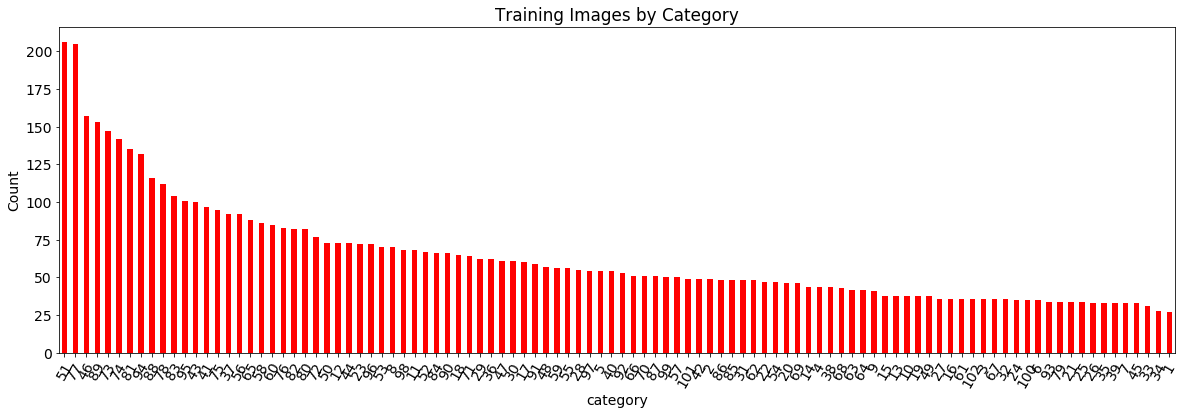

In [3]:
cat_df.set_index('category')['n_train'].plot.bar(color='r', figsize=(20, 6))
plt.xticks(rotation=60)
plt.ylabel('Count')
plt.title('Training Images by Category');

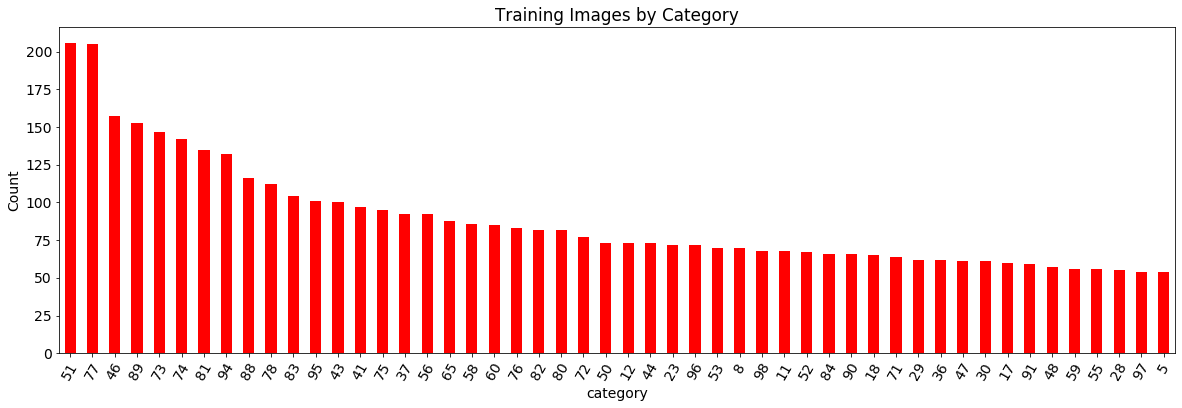

In [4]:
# histogram top 50 categories
cat_df.set_index('category').iloc[:50]['n_train'].plot.bar(color='r', figsize=(20, 6))
plt.xticks(rotation=60)
plt.ylabel('Count')
plt.title('Training Images by Category');

#### Distribution of Images Sizes

The images themselves have vastly different shapes. We can see this by looking at the stats of images sizes by category.

In [5]:
img_dsc = image_df.groupby('category').describe()
img_dsc.head()

height                                                             \
          count        mean        std    min    25%    50%     75%    max   
category                                                                     
1          27.0  513.629630  49.805891  500.0  500.0  500.0  500.00  714.0   
10         38.0  534.605263  63.368736  500.0  500.0  500.0  547.25  752.0   
100        35.0  523.000000  55.843268  500.0  500.0  500.0  504.50  687.0   
101        49.0  550.714286  83.005020  500.0  500.0  501.0  582.00  807.0   
102        36.0  537.277778  74.165688  500.0  500.0  500.0  518.25  812.0   

         width                                                              
         count        mean        std    min     25%    50%     75%    max  
category                                                                    
1         27.0  619.222222  70.929181  500.0  558.50  646.0  666.00  750.0  
10        38.0  587.710526  85.508940  500.0  500.00  561.5  667.00  752.0  
100       35.0  613.485714  88.722426  500.0  501.00  658.0  667.00  751.0  
101       49.0  580.408163  87.523549  500.0  500.00  530.0  667.00  778.0  
102       36.0  592.083333  83.482205  500.0  506.75  579.5  649.75  762.0

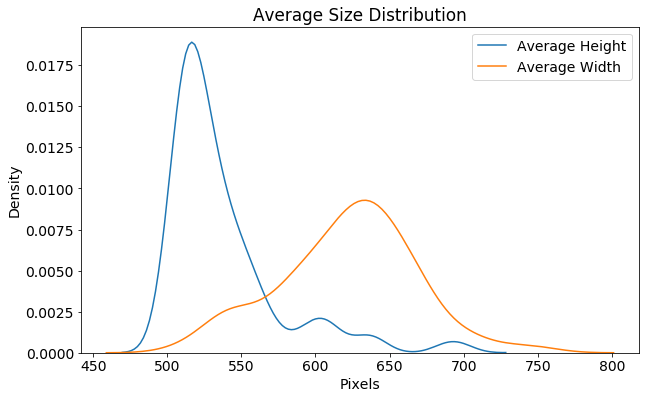

In [6]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.kdeplot(
    img_dsc['height']['mean'], label='Average Height')
sns.kdeplot(
    img_dsc['width']['mean'], label='Average Width')
plt.xlabel('Pixels')
plt.ylabel('Density')
plt.title('Average Size Distribution');

When we use the images in the pre-trained network, we'll have to reshape them to 224 x 224. This is the size of Imagenet images and is therefore what the model expects. The images that are larger than this will be truncated while the smaller images will be interpolated. 

# Image Preprocessing

To prepare the images for our network, we have to resize them to 224 x 224 and normalize each color channel by subtracting a mean value and dividing by a standard deviation. We will also augment our training data in this stage. These operations are done using image `transforms`, which prepare our data for a neural network.

### Data Augmentation

Because there are a limited number of images in some categories, we can use image augmentation to artificially increase the number of images "seen" by the network. This means for training, we randomly resize and crop the images and also flip them horizontally. A different random transformation is applied each epoch (while training), so the network effectively sees many different versions of the same image. All of the data is also converted to Torch `Tensor`s before normalization. The validation and testing data is not augmented but is only resized and normalized. The normalization values are standardized for Imagenet. 

In [7]:
# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=45),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'val':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

### Examples of Augmentation

To show how augmentation works, we need to write a function that will plot a tensor as an image.

In [8]:
def imshow(image):
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

def imshow_tensor(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image

We'll work with two example images and apply the train transformations.

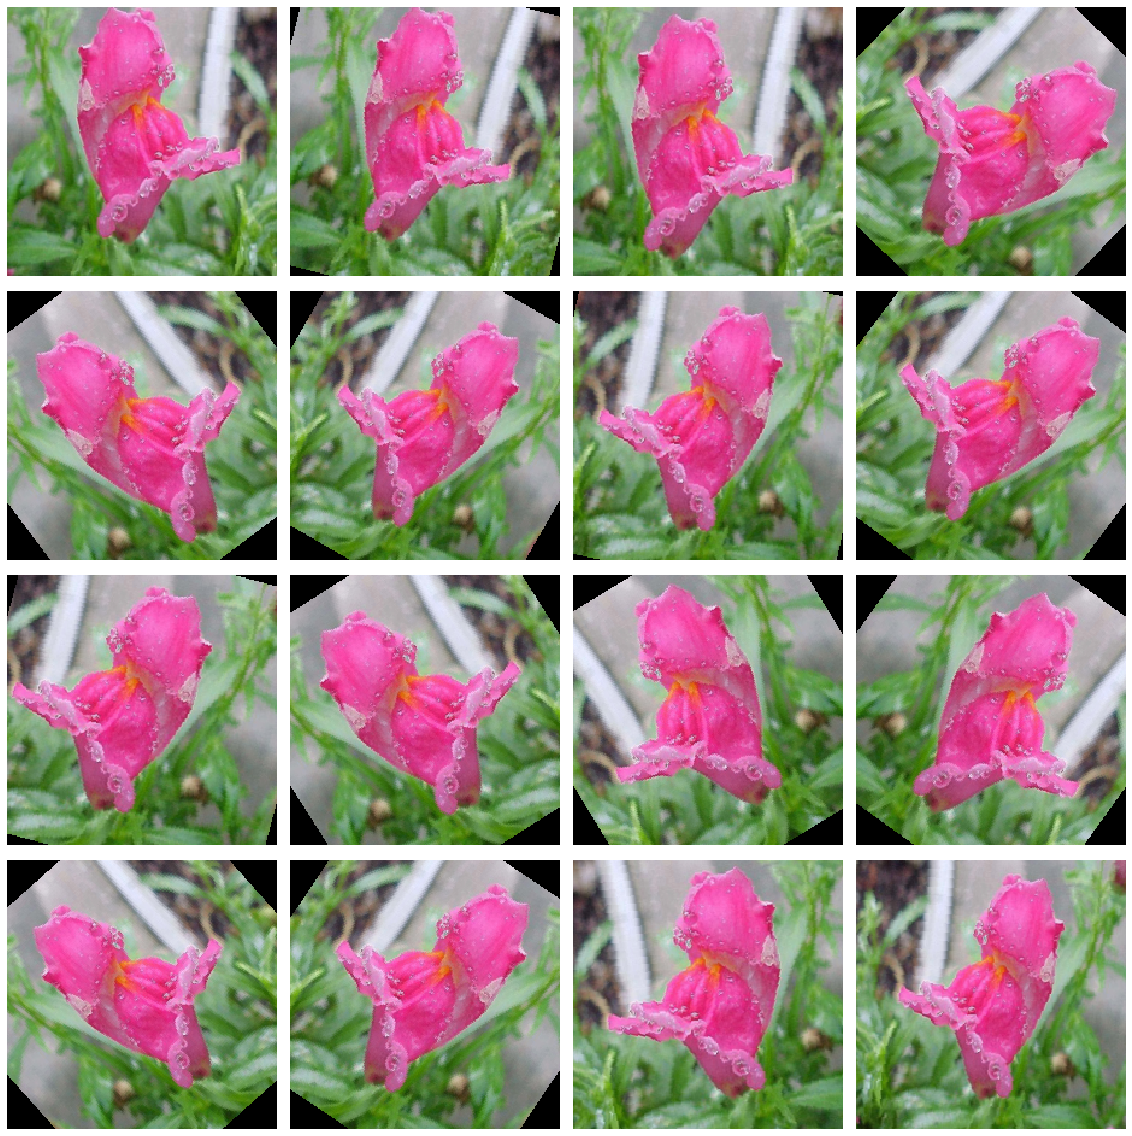

In [9]:
ex_img = Image.open(traindir + '64/image_06117.jpg')
ex_img = Image.open(traindir + '99/image_07892.jpg')
ex_img = Image.open(traindir + '11/image_03175.jpg')
#imshow(ex_img)
t = image_transforms['train']
plt.figure(figsize=(16, 16))

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    _ = imshow_tensor(t(ex_img), ax=ax)

plt.tight_layout();

## Data Iterators

To avoid loading all of the data into memory at once, we use training `DataLoaders`. First, we create a dataset object from the image folders, and then we pass these to a `DataLoader`. At training time, the `DataLoader` will load the images from disk, apply the transformations, and yield a batch. To train and validation, we'll iterate through all the batches in the respective `DataLoader`. 

One crucial aspect is to `shuffle` the data before passing it to the network. This means that the ordering of the image categories changes on each pass through the data (one pass through the data is one training epoch). 

In [10]:
# Datasets from each folder
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'val':
    datasets.ImageFolder(root=validdir, transform=image_transforms['val']),
    'test':
    datasets.ImageFolder(root=testdir, transform=image_transforms['test'])
}
class_names = data['train'].classes
# Dataloader iterators
dataloaders = {'example': DataLoader(data['train'], batch_size=16, shuffle = True, num_workers=4)}

### The shape of a batch is 
(batch_size, color_channels, height, width). We set batchsize = 16 for the visualization

In [11]:
features, labels = next(iter(dataloaders['example']))
features.shape, labels.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16]))

In [12]:
n_classes = len(cat_df)
print('There are {} different classes.'.format(n_classes))
n_classes == len(class_names)

There are 102 different classes.


True

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [13]:
import json
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)   
cat_to_name

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

### Finally, visualize a training batch 
Need to undo normalization

In [18]:
def batch_show(inp, title=None):
    """Imshow for a TorchTensor"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(16, 16))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause so that plots are updated
    

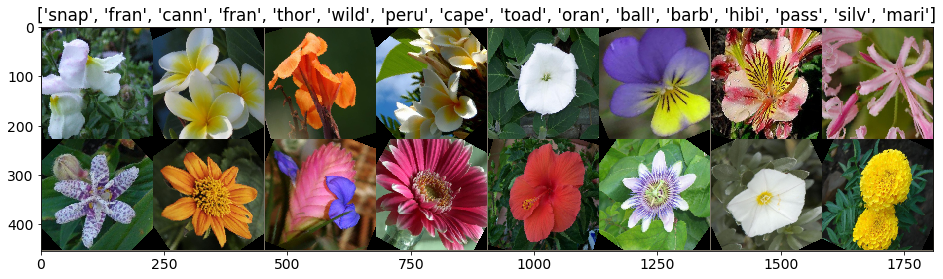

In [19]:
features, labels = next(iter(dataloaders['example']))
## Make a grid from batch
out = torchvision.utils.make_grid(features)
#batch_show(out, title=[class_names[x] for x in labels])
batch_show(out, title=[cat_to_name[str(class_names[x])][:4] for x in labels])

### This concludes data exploration and visualization
